## The Distribution with Dephasing noise

$|\psi> = \lambda_0 |01> + \lambda_1 |10>$

$\rho = (1-d) |\psi><\psi| + d (\lambda_0^2 |01><01| + \lambda_1^2 |10><10|)$ 

In [17]:
import numpy as np
from numpy import kron
import math
from math import sqrt
from random import random
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from itertools import product
from matplotlib import colors
import time
from tqdm import tqdm
from itertools import product



def new_index(x):   # 012345 --> 123450
    b  = bin(x)[2:].zfill(6) # x in binary b0..b5
    y = int(b[1:]+b[0], 2)
    return y

def change_qbit_order(x): # 012345 --> 123450
    x_ordered = np.zeros_like(x)
    for i in range(64):
        for j in range(64):
            x_ordered[new_index(i), new_index(j)] = x[i,j]
    return x_ordered



def PP(w,z,u,v,lambda_0,lambda_1,d):
    
    ## settign states
    state_0 = np.array([1,0])
    state_1 = np.array([0,1])

    state_00 = kron(state_0,state_0).reshape(4,1)
    state_01 = kron(state_0,state_1).reshape(4,1)
    state_10 = kron(state_1,state_0).reshape(4,1)
    state_11 = kron(state_1,state_1).reshape(4,1)

    psi = (lambda_0*state_01 + lambda_1*state_10)
    
    rho_noiseless = np.dot(psi, psi.T)
    rho_dephasing = lambda_0**2 *np.dot(state_01, state_01.T) + lambda_1**2 *np.dot(state_10, state_10.T)

    rho = (1-d)*rho_noiseless + d*rho_dephasing
    total_rho = kron(kron(rho,rho),rho)
    total_rho_ordered = change_qbit_order(total_rho)


    
    
    
    # Setting Measurment 
    out_00 = z*state_00 + w*state_11
    out_01 = w*state_00 - z*state_11
    out_10 = u*state_01 + v*state_10
    out_11 = v*state_01 - u*state_10
    
    M_state = np.array([[out_00, out_01],[out_10, out_11]])
    
    ## Resulting distribution
    
    
    




    p = np.zeros((2,2,2,2,2,2))
    p = p.tolist()


    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):

        total_M_state = kron(kron(M_state[a1,a2], M_state[b1,b2]), M_state[c1,c2])
        E = np.dot(total_M_state, total_M_state.T)
        p[a1][a2][b1][b2][c1][c2] = np.trace(np.dot(E, total_rho_ordered))
        
    return p

# find epsilon...... it only depens on  V !!!



The LP is this:

\begin{align}
&P(a_1,a_2,b_1,b_2,c_1,c_2) = \sum_{t_a, t_b, t_c \Rightarrow a_1, b_1, c_1}{ q(t_a)q(t_b)q(t_c) \ P(a_2,b_2,c_2|t_a, t_b, t_c)}\\
&\sum_{a_2,b_2,c_2}{P(a_2,b_2,c_2|t_a, t_b, t_c)} = 1 \ \ \ \forall t_a, t_b, t_c\\
&P(a_2|0, t_b, t_c) = P(a_2|1, t_b, t_c) \Leftrightarrow \sum_{b_2,c_2} {P(a_2,b_2,c_2|0, t_b, t_c)} - \sum_{b_2,c_2}P(a_2,b_2,c_2|1, t_b, t_c) = 0
\end{align}

Which becomes:

\begin{align}
&P_Q(a_1,a_2,b_1,b_2,c_1,c_2) = \sum_{t_a, t_b, t_c \Rightarrow a_1, b_1, c_1}{ q(t_a)q(t_b)q(t_c) \ P(a_2,b_2,c_2|t_a, t_b, t_c)} + (P_Q - P_C)\ e \\
&\sum_{a_2,b_2,c_2}{P(a_2,b_2,c_2|t_a, t_b, t_c)} = 1 \ \ \ \forall t_a, t_b, t_c\\
&P(a_2|0, t_b, t_c) = P(a_2|1, t_b, t_c) \Leftrightarrow \sum_{b_2,c_2} {P(a_2,b_2,c_2|0, t_b, t_c)} - \sum_{b_2,c_2}P(a_2,b_2,c_2|1, t_b, t_c) = 0
\end{align}

In [37]:
import numpy as np
import cvxpy as cp
from itertools import product
from tqdm import tqdm

# Constants
l0 = np.sqrt(0.22)
l1 = np.sqrt(1 - l0**2)

q = l0**2
q_a = [q, 1 - q]
q_b = [q, 1 - q]
q_c = [q, 1 - q]


# Construct normalization constraints A_2
A_2 = np.zeros((8, 65))
for ta, tb, tc in product(range(2), repeat=3):
    constraint_it = ta * 4 + tb * 2 + tc
    for a2, b2, c2 in product(range(2), repeat=3):
        var_it = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
        A_2[constraint_it, var_it] = 1

# Construct network independence constraints
A_3a = np.zeros((8, 65))
for a2, tb, tc in product(range(2), repeat=3):
    constraint_it = a2 * 4 + tb * 2 + tc
    for b2, c2, ta in product(range(2), repeat=3):
        var_it = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
        A_3a[constraint_it, var_it] = (-1) ** ta

A_3b = np.zeros((8, 65))
for b2, ta, tc in product(range(2), repeat=3):
    constraint_it = b2 * 4 + ta * 2 + tc
    for a2, c2, tb in product(range(2), repeat=3):
        var_it = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
        A_3b[constraint_it, var_it] = (-1) ** tb

A_3c = np.zeros((8, 65))
for c2, ta, tb in product(range(2), repeat=3):
    constraint_it = c2 * 4 + ta * 2 + tb
    for a2, b2, tc in product(range(2), repeat=3):
        var_it = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
        A_3c[constraint_it, var_it] = (-1) ** tc

# Optimization parameters
N_it = 50
phi_u_list = np.linspace(0, np.pi / 2, N_it)
phi_w_list = np.linspace(0, np.pi / 4, N_it // 2)
e_map = np.zeros((N_it, N_it // 2))

# Main loop
for i in tqdm(range(N_it)):
    for j in range(N_it // 2):
        phi_u = phi_u_list[i]
        phi_w = phi_w_list[j]

        u = np.cos(phi_u)
        v = np.sin(phi_u)
        w = np.cos(phi_w)
        z = np.sin(phi_w)

        # Evaluate probabilities (you must define this)
        p_Q = PP(w, z, u, v, l0, l1, d=0)
        p_C = PP(w, z, u, v, l0, l1, d=1)

        A_1 = np.zeros((64, 65))
        b_1 = np.zeros(64)

        for a1, a2, b1, b2, c1, c2 in product(range(2), repeat=6):
            row = a1 * 32 + a2 * 16 + b1 * 8 + b2 * 4 + c1 * 2 + c2
            b_1[row] = p_Q[a1][a2][b1][b2][c1][c2]
            for ta, tb, tc in product(range(2), repeat=3):
                if (a1 == (tb + tc + 1) % 2) and (b1 == (ta + tc + 1) % 2) and (c1 == (ta + tb + 1) % 2):
                    col = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
                    A_1[row, col] = q_a[ta] * q_b[tb] * q_c[tc]
                    A_1[row, 64] = p_Q[a1][a2][b1][b2][c1][c2] - p_C[a1][a2][b1][b2][c1][c2]

        A = np.concatenate([A_1, A_2, A_3a, A_3b, A_3c])
        b_2 = np.ones(8)
        b_3 = np.zeros(24)
        b = np.concatenate([b_1, b_2, b_3])

        # CVXPY LP
        x = cp.Variable(65)
        constraints = [
            A @ x == b,
            x[:-1] >= 0,
            x[:-1] <= 1
            ]
        objective = cp.Minimize(x[64])
        prob = cp.Problem(objective, constraints)
        prob.solve(solver="MOSEK", verbose=False)

        e_map[i, j] = prob.value

# Mirror the map for symmetry in w
e_map_flip = np.flip(e_map, axis=1)
e_map_final = np.concatenate((e_map, e_map_flip), axis=1)
e_map_final[e_map_final < 0] = 0

100%|███████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


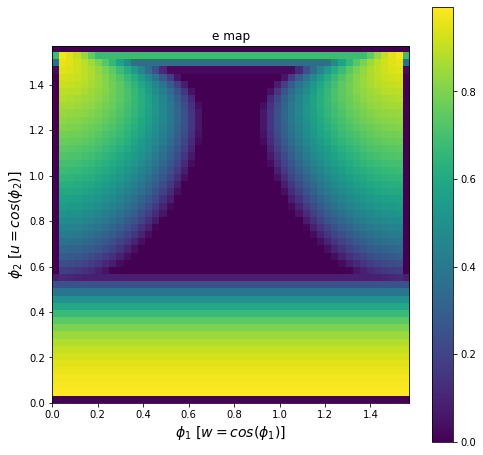

In [39]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_title("e map")

plt.imshow(e_map_final,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

# Add colorbar
plt.colorbar()

plt.xlabel("$\phi_1 \ [w=cos(\phi_1)]$",
             size = 14)
plt.ylabel("$\phi_2 \ [u=cos(\phi_2)]$",
             size = 14)

plt.show()

Max d is  80.58318898221427 for:
$phi_1$ 0.06544984694978735
$ph2_1$ 0.0320570678937734


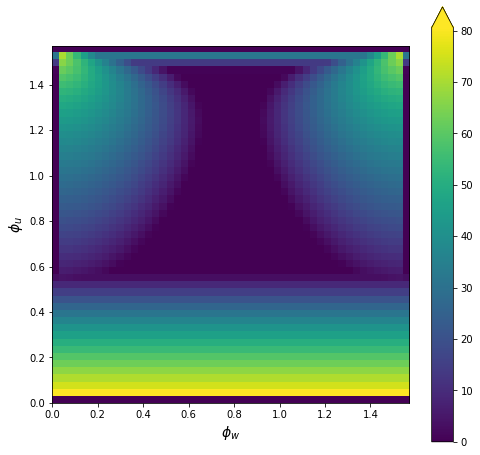

In [40]:
d_map = 1-((1-e_map_final)**(1/3))

d_map = d_map*100 ##### in %

fig, ax = plt.subplots(figsize=(8,8))

#ax.set_title("d map")


plt.imshow(d_map,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

# Add colorbar
plt.colorbar(extend="max")

plt.xlabel("$\phi_w$",
             size = 14)
plt.ylabel("$\phi_u$",
             size = 14)

from numpy import unravel_index

i_max, j_max = unravel_index(d_map.argmax(), d_map.shape)
phi_u_max = phi_u_list[i_max]
phi_w_max = phi_w_list[j_max]

print("Max d is ", np.max(d_map), "for:")
print("$phi_1$", phi_w_max)
print("$ph2_1$", phi_u_max)

plt.show()

Max d is  0.8058318898221426 for:
$phi_1$ 0.06544984694978735
$ph2_1$ 0.015866629563584814


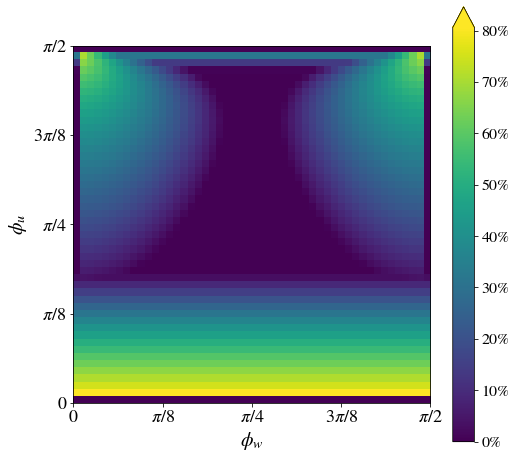

In [55]:
import matplotlib
import matplotlib.ticker as mtick
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...


d_map = 1-((1-e_map_final)**(1/3))

d_map = d_map ##### in %

fig, ax = plt.subplots(figsize=(8,8))

#ax.set_title("d map")
#ax.set_title("Dephasing Noise Map", size = 20)



plt.imshow(d_map,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

# Add colorbar
cbar= plt.colorbar(extend="max")
cbar.ax.tick_params(labelsize=16)

# Format the colorbar to display percentages
formatter = mtick.FuncFormatter(lambda x, pos: '{:.0%}'.format(x))
cbar.ax.yaxis.set_major_formatter(formatter)

plt.xlabel("$\phi_w$", size = 20)
plt.ylabel("$\phi_u$", size = 20)


theta = np.linspace(0, np.pi/2, 5)
plt.xticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

plt.yticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)



from numpy import unravel_index

i_max, j_max = unravel_index(d_map.argmax(), d_map.shape)
phi_u_max = phi_u_list[i_max]
phi_w_max = phi_w_list[j_max]

print("Max d is ", np.max(d_map), "for:")
print("$phi_1$", phi_w_max)
print("$ph2_1$", phi_u_max)



plt.show()

In [64]:
import numpy as np
import cvxpy as cp
from itertools import product

def RGB4_Dephasing_plot(l0, N_it):
    l1 = np.sqrt(1 - l0**2)

    q = l0**2
    q_a = [q, 1 - q]
    q_b = [q, 1 - q]
    q_c = [q, 1 - q]


    # Normalization constraints A_2
    A_2 = np.zeros((8, 65))
    for ta, tb, tc in product(range(2), repeat=3):
        constraint_it = ta * 4 + tb * 2 + tc
        for a2, b2, c2 in product(range(2), repeat=3):
            var_it = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
            A_2[constraint_it, var_it] = 1

    # Network independence constraints A_3a, A_3b, A_3c
    A_3a = np.zeros((8, 65))
    for a2, tb, tc in product(range(2), repeat=3):
        constraint_it = a2 * 4 + tb * 2 + tc
        for b2, c2, ta in product(range(2), repeat=3):
            var_it = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
            A_3a[constraint_it, var_it] = (-1) ** ta

    A_3b = np.zeros((8, 65))
    for b2, ta, tc in product(range(2), repeat=3):
        constraint_it = b2 * 4 + ta * 2 + tc
        for a2, c2, tb in product(range(2), repeat=3):
            var_it = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
            A_3b[constraint_it, var_it] = (-1) ** tb

    A_3c = np.zeros((8, 65))
    for c2, ta, tb in product(range(2), repeat=3):
        constraint_it = c2 * 4 + ta * 2 + tb
        for a2, b2, tc in product(range(2), repeat=3):
            var_it = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
            A_3c[constraint_it, var_it] = (-1) ** tc

    # Logarithmic spaced phi_u list
    phi_u_list = np.logspace(-10, np.log10(np.pi / 2), num=N_it)

    e_map = np.zeros(N_it)

    for i in tqdm(range(N_it)):

        phi_u = phi_u_list[i]
        phi_w = 0.0
        
        u = np.cos(phi_u)
        v = np.sin(phi_u)
        w = np.cos(phi_w)
        z = np.sin(phi_w)

        # User-defined probability function PP returns 6D ndarray shape [2][2][2][2][2][2]
        p_Q = PP(w, z, u, v, l0, l1, d=0)
        p_C = PP(w, z, u, v, l0, l1, d=1)

        # Build A_1 and b_1
        A_1 = np.zeros((64, 65))
        b_1 = np.zeros(64)
        for a1, a2, b1, b2, c1, c2 in product(range(2), repeat=6):
            row = a1 * 32 + a2 * 16 + b1 * 8 + b2 * 4 + c1 * 2 + c2
            b_1[row] = p_Q[a1][a2][b1][b2][c1][c2]
            for ta, tb, tc in product(range(2), repeat=3):
                if (a1 == (tb + tc + 1) % 2) and (b1 == (ta + tc + 1) % 2) and (c1 == (ta + tb + 1) % 2):
                    col = a2 * 32 + b2 * 16 + c2 * 8 + ta * 4 + tb * 2 + tc
                    A_1[row, col] = q_a[ta] * q_b[tb] * q_c[tc]
                    A_1[row, 64] = p_Q[a1][a2][b1][b2][c1][c2] - p_C[a1][a2][b1][b2][c1][c2]

        # Combine all constraint matrices
        A = np.concatenate([A_1, A_2, A_3a, A_3b, A_3c])

        # Remove duplicate rows by rounding (optional)
        _, inds = np.unique(np.round(A, decimals=10), axis=0, return_index=True)
        A = A[inds]

        # Combine b vectors accordingly
        b_2 = np.ones(8)
        b_3 = np.zeros(24)
        b = np.concatenate([b_1, b_2, b_3])[inds]

        # Define LP variable
        x = cp.Variable(65)

        constraints = [
            A @ x == b,
            x[:-1] >= 0,
            x[:-1] <= 1
        ]

        objective = cp.Minimize(x[64])
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.MOSEK, verbose=False)

        e_map[i] = prob.value

    print("\nDone.")
    return e_map


In [65]:
l0 = np.cos(0.342*np.pi)#lambda0
N_it = 200
e_array = RGB4_Dephasing_plot(l0, N_it)
e_array[e_array < 0] = 0

d_array = 1-((1-e_array)**(1/3))

100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 40.91it/s]


Done.


Max d : 86.7 % for phi_u = 0.0098


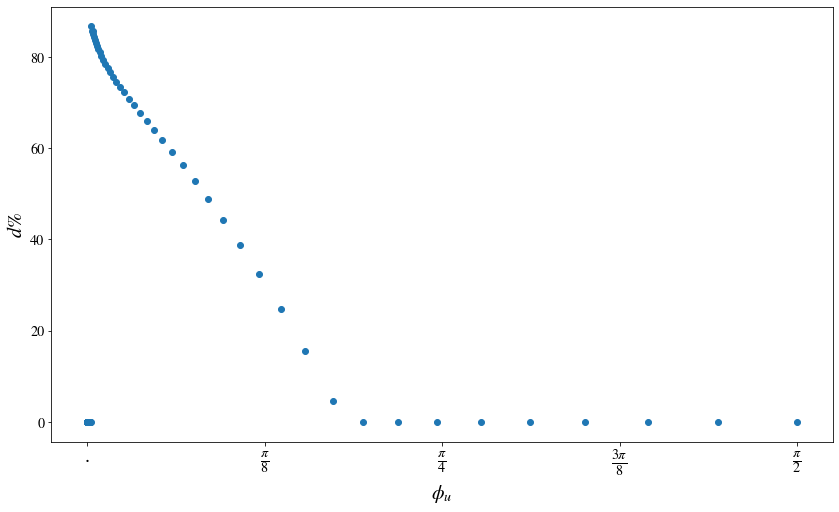

In [77]:
fig, ax = plt.subplots(figsize=(14,8))

phi_u_list = np.logspace(-10, np.log10(np.pi/2), num = N_it)

plt.scatter(phi_u_list, 100*d_array)

plt.xlabel("$\phi_u$", size = 20)
plt.ylabel("$d \% $", size = 20)


theta = np.linspace(0, np.pi/2, 5)
plt.xticks(theta, ['.','$'+r'\frac{\pi}{8}$','$'+r'\frac{\pi}{4}$','$'+r'\frac{3\pi}{8}$', '$'+r'\frac{\pi}{2}$'])

plt.yticks(fontsize=14)
plt.xticks(fontsize=20)

max_d = np.max(d_array)
max_idx = np.argmax(d_array)
phi_u_star = phi_u_list[max_idx]

print("Max d :", np.round(max_d*100,1), "% for phi_u =",np.round(phi_u_star,4))
plt.show()